In [30]:
import pandas as pd
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from src.datasets import daocensus_text
import src.utils.notebooks as nbutils

sns.set_theme()
plt.rcParams['figure.dpi'] = 600

In [31]:
# 'ORG_NAME', 'ORG_PLATFORM', 'SPLITS_FREQ', 'SPLITS_NORMALIZE', 'LAST_SPLITS', 'USE_ORG_NAMES'

ORG_NAME = 'gm DAO'
ORG_PLATFORM = 'snapshot'
USE_ORG_NAMES = True

# Not used
SPLITS_FREQ = ...
SPLITS_NORMALIZE = ...
LAST_SPLITS = ...
CUTOFF_DATE_STR = ...

In [32]:
dfv, dfp = daocensus_text.get('./data/daos-census-text', ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES)
dfp = dfp.set_index('id')
print(dfv.info())
print(dfp.info())

Warning, removing 1 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 79616 to 79616
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   platform       1 non-null      object        
 1   name           1 non-null      object        
 2   id             1 non-null      object        
 3   proposal       1 non-null      category      
 4   deployment     1 non-null      object        
 5   platform_vote  1 non-null      object        
 6   voter          1 non-null      category      
 7   date           1 non-null      datetime64[ns]
 8   choice         1 non-null      object        
 9   weight         1 non-null      float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 90.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 1 entries, 7cbda47f-a97b-58d9-9f71-77dce7a6aa15 to 7cbda47f-a97b-58d9-9f71-77dce7a6aa15

# Exploración de datos de Decentraland

In [23]:
print(f"{ORG_NAME} tiene {len(dfv)} votos de {dfv['voter'].nunique()} voters en {dfv['proposal'].nunique()} propuestas")

Aave - Aavegotchi tiene 2326043 votos de 73446 voters en 719 propuestas


In [24]:
dfd = dfp[['platform', 'name', 'platform_deployment']].drop_duplicates()
dfd

,platform,name,platform_deployment
id,,,
0b125a58-0080-54de-b4d8-4e26660284bf,snapshot,Aave - Aavegotchi,aavegotchi.eth
25374969-d396-52f7-b052-4d8a9244010a,snapshot,Aave - Aavegotchi,aave.eth


## Histograma de votos por usuario

73446
4204
count    73446.000000
mean        31.670111
std         38.817286
min          1.000000
50%         13.000000
90%         85.000000
95%        108.000000
99%        166.000000
max        408.000000
dtype: float64


Cannot show ipywidgets in text

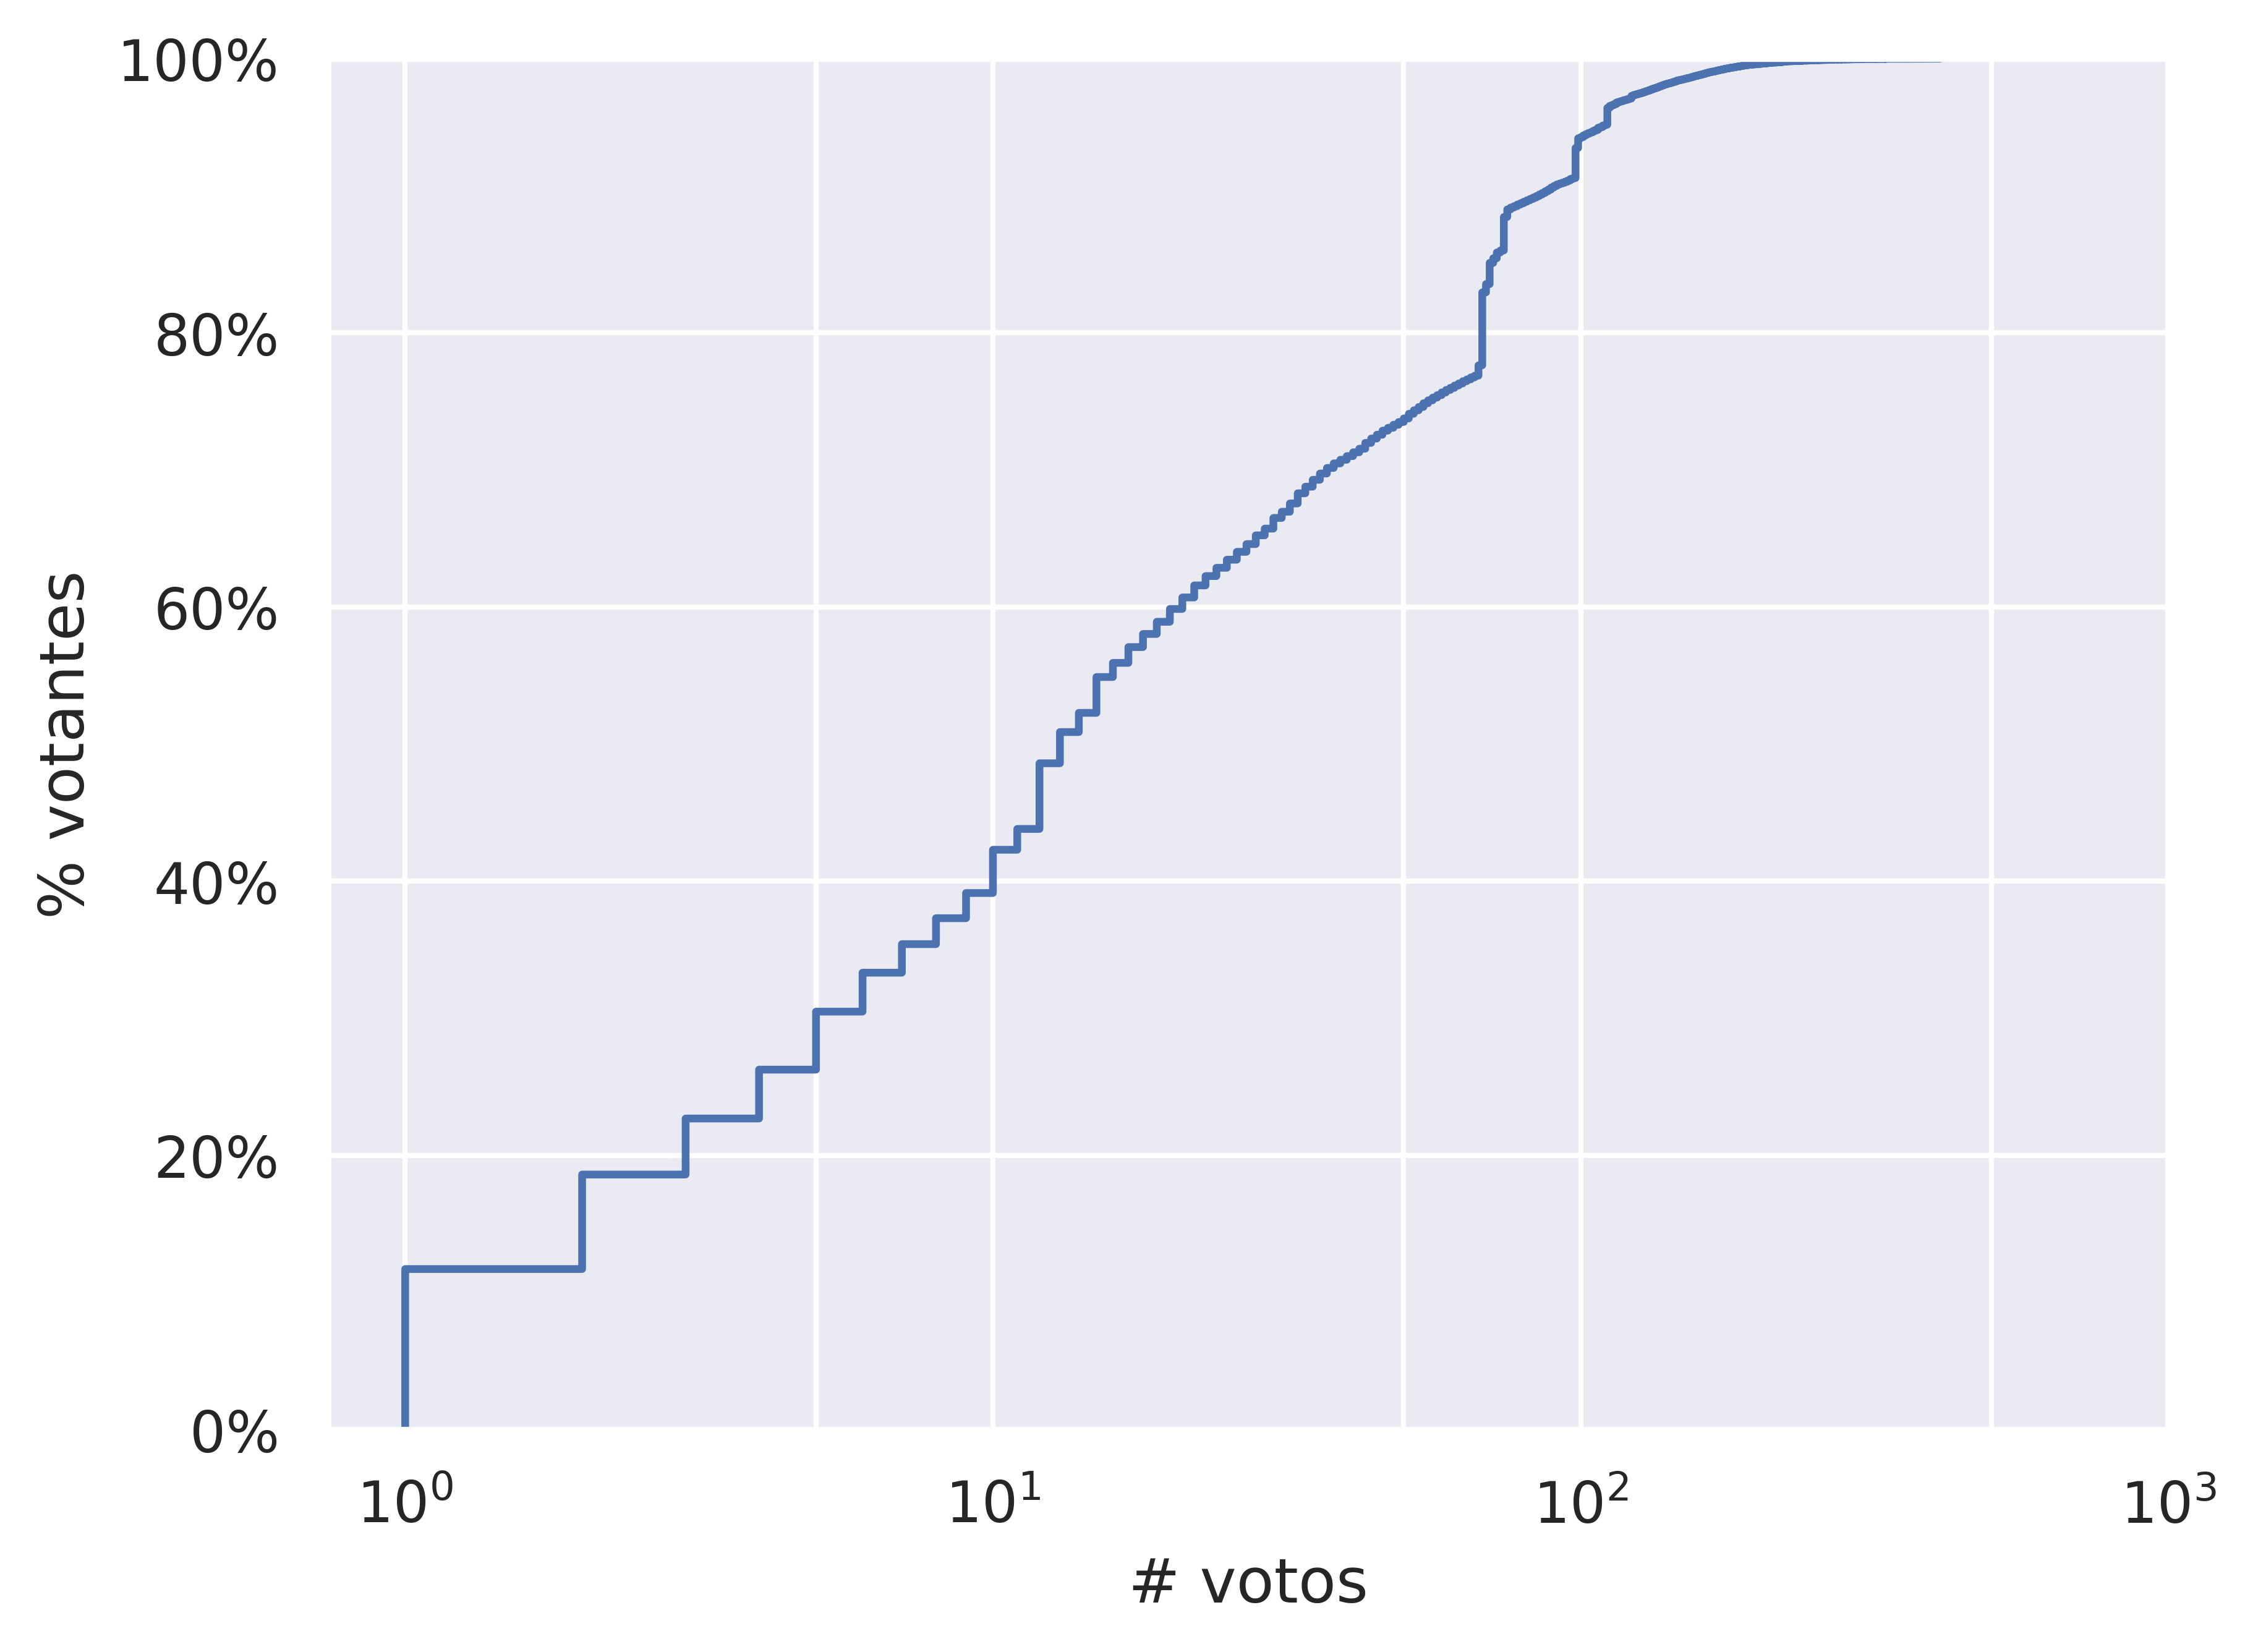

In [25]:
_toplot = dfv.groupby('voter').size()
# _toplot = _toplot[_toplot < 40]
print( len(_toplot) )
print( (_toplot > 100).sum() )
print(_toplot.describe(percentiles=[.5, .9, .95, .99]))
# _toplot.plot.hist(log=True)
ax = sns.ecdfplot(_toplot, log_scale=True)
plt.xlabel('# votos')
plt.ylabel('% votantes')

ax.set_xticks([1, 5, 10, 50, 100, 500, 1000])
# ax.xaxis.set_major_locator(mtick.MultipleLocator(10))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
nbutils.download_matplotlib(ax.figure, f'04_hybrid_ecdf_voters_{ORG_NAME}.pdf')

## Histograma de votos por propuesta

count      720.000000
mean      3231.104167
std       4727.005372
min          1.000000
50%       1287.500000
75%       2561.500000
90%      10985.700000
95%      16064.150000
99%      17264.050000
max      21321.000000
Name: votes_count, dtype: float64
591


Cannot show ipywidgets in text

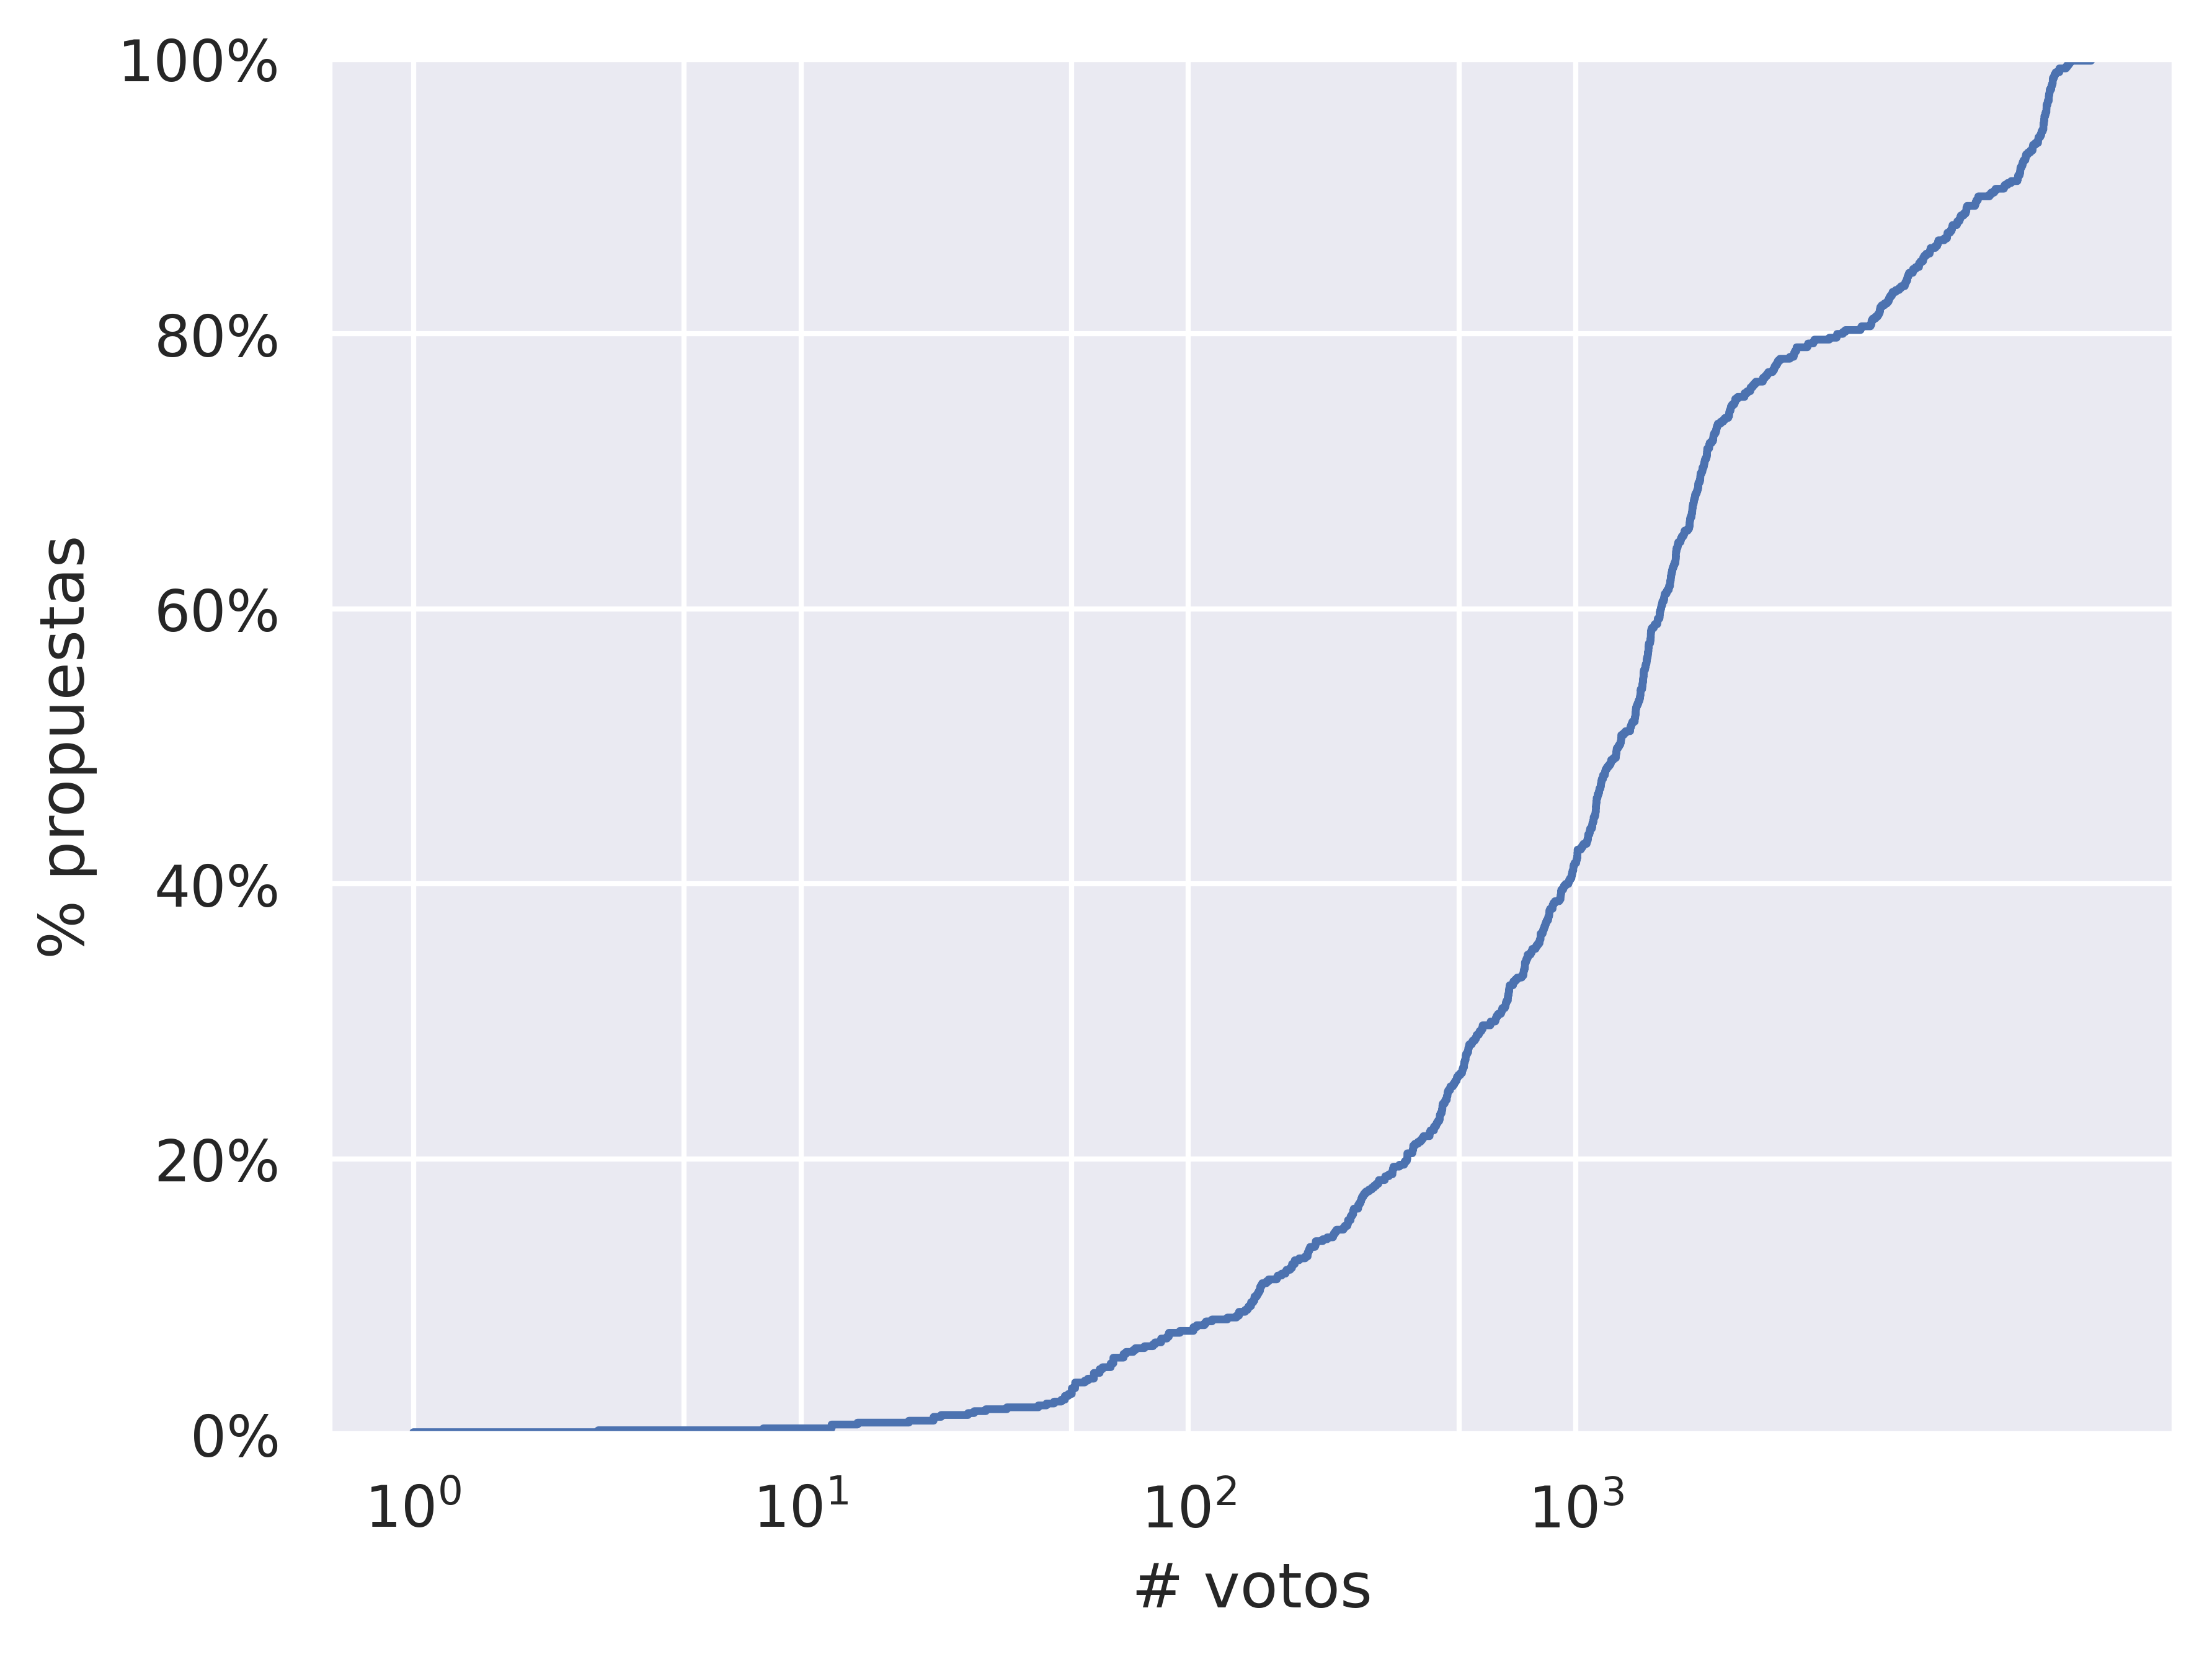

In [26]:
_toplot = dfp['votes_count']
print(_toplot.describe(percentiles=[.5,.75,.9, .95, .99]))
print( (_toplot > 300).sum() )

ax = sns.ecdfplot(_toplot, log_scale=True)
ax.set_xticks([1, 5, 10, 50, 100, 500, 1000])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.xlabel('# votos')
plt.ylabel('% propuestas')

nbutils.download_matplotlib(ax.figure, f'04_hybrid_ecdf_proposals_{ORG_NAME}.pdf')

count      719.000000
mean      3235.108484
std       4729.067982
min          1.000000
50%       1292.000000
75%       2565.000000
90%      11060.400000
95%      16064.300000
99%      17265.100000
max      21321.000000
dtype: float64
590


<Axes: ylabel='Proportion'>

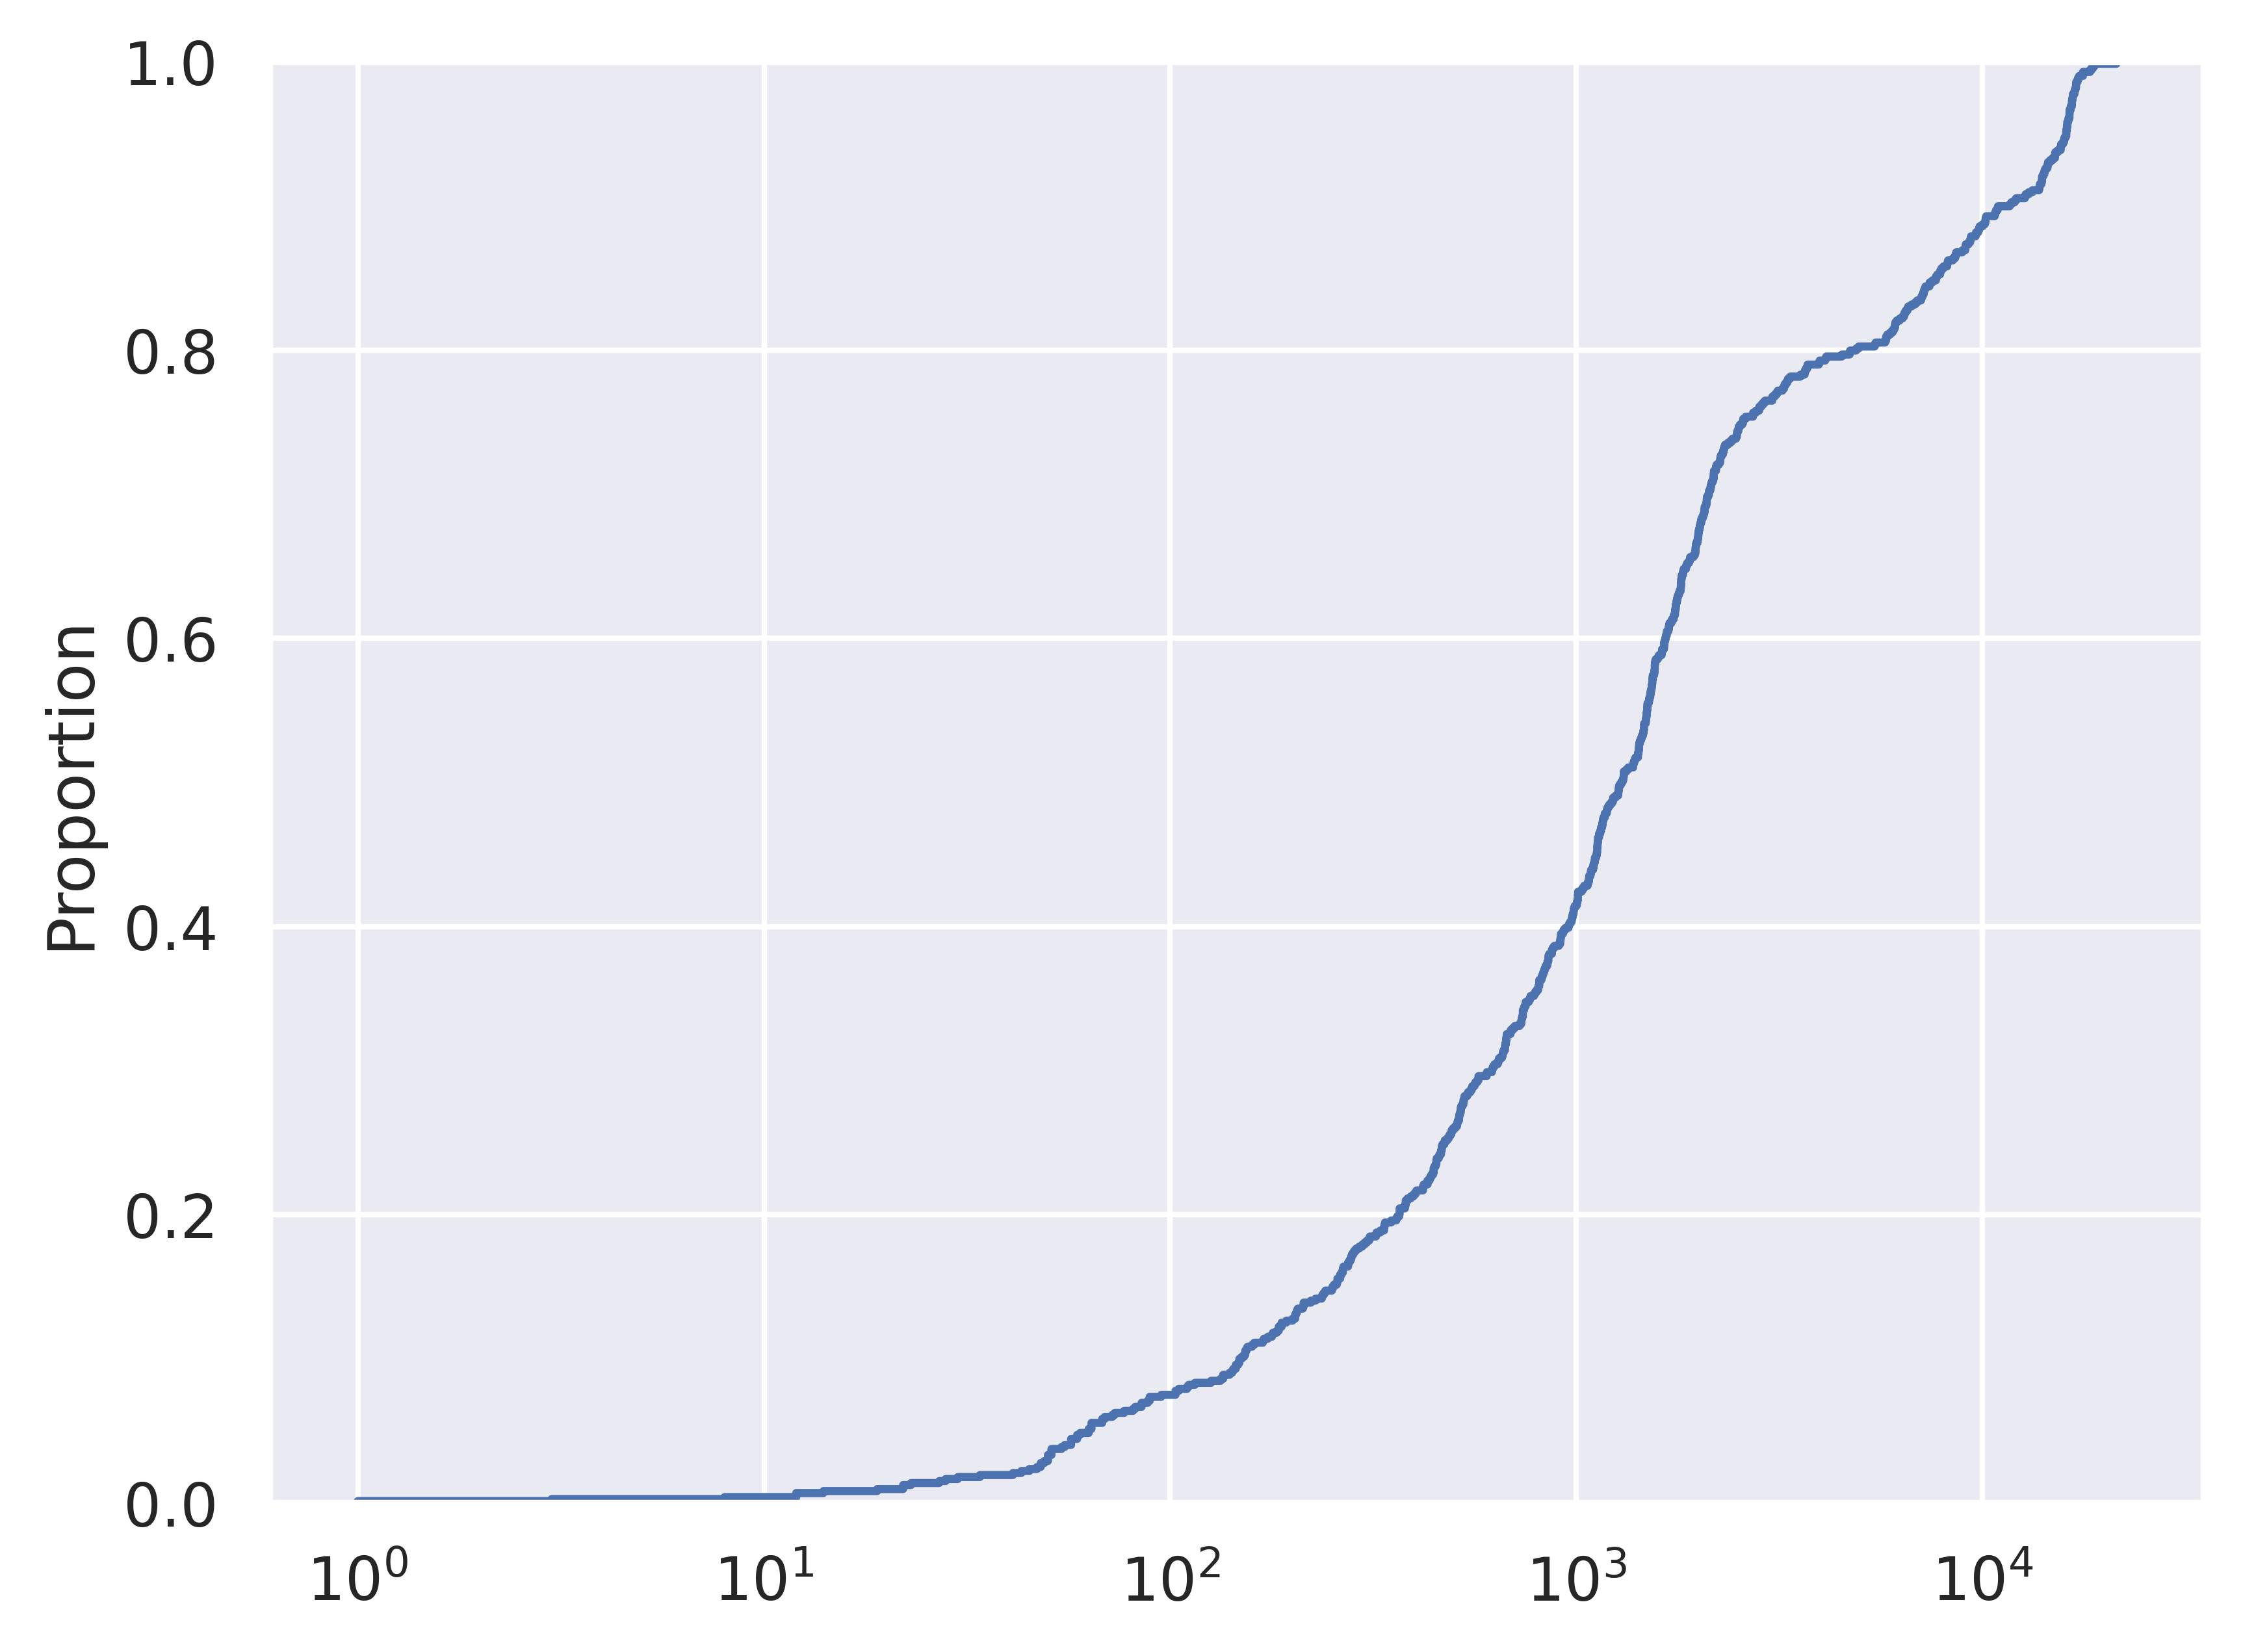

In [27]:
_toplot = dfv.groupby('proposal').size()
print(_toplot.describe(percentiles=[.5,.75,.9, .95, .99]))
print( (_toplot > 300).sum() )
sns.ecdfplot(_toplot, log_scale=True)

### Usuarios activos

In [28]:
# dfv.set_index('date').sort_index()['voter'].tolist()
# for x in dfv.set_index('date').sort_index()['voter'].items():
#     print(x)

In [29]:
# import numba
from tqdm.autonotebook import tqdm
import rolling
import datetime as dt

tqdm.pandas(total=len(dfv))

# WINDOW_SIZE = '30D'
WINDOW_SIZE = dt.timedelta(days=30)

RESAMPLE_FREQ = '12h'

# @numba.jit(nopython=True)
# def nunique(arr):
#     return len(set(arr))

# Rolling no acepta tipos no númericos en la agregación, por lo que es necesario convertir la categoría a entero
# Por ejemplo, usando el código que le asigna Pandas
# dfv['ucode'] = dfv['voter'].cat.codes
#_cnt = dfv.set_index('date').sort_index().rolling(WINDOW_SIZE)['ucode'].progress_apply(nunique, raw=True).rename('cnt')

# Al final resulta que lo mejor era ir a por la solución O(1)
_voters = dfv.set_index('date').sort_index()['voter'] # .cat.codes
r = tqdm(
    rolling.arithmetic.Nunique(_voters.items(), WINDOW_SIZE, window_type='indexed'),
    total=len(dfv),
)
_cnt = pd.Series(r, index=_voters.index)
# Need to resample or there would be too many points
_cnt = _cnt.resample(RESAMPLE_FREQ).max()

print(dfv['date'].min(), dfv['date'].max())
ax = sns.lineplot(_cnt)
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('# usuarios activos')
plt.xlim(dfv['date'].min(), dfv['date'].max())
nbutils.download_matplotlib(ax.figure, f'04c_rolling_voters_{WINDOW_SIZE}_{ORG_NAME}.png')

  0%|          | 0/2326043 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Cuando se unen los usuarios

Es decir, cuando votan por primera vez

In [ ]:
_toplot = dfv.groupby('voter')['date'].min()
_toplot = _toplot.sort_values().to_frame()
_toplot['cnt'] = 1
_toplot['cumcnt'] = _toplot['cnt'].cumsum()
ax = sns.lineplot(_toplot, x='date', y='cumcnt')
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('# Votantes')

nbutils.download_matplotlib(ax.figure, f'04_hybrid_cumcnt_users_{ORG_NAME}.pdf')

## Cuando se crean las propuestas

In [ ]:
_toplot = dfv.groupby('proposal')['date'].min()
_toplot = _toplot.sort_values().to_frame()
_toplot['cnt'] = 1
_toplot['cumcnt'] = _toplot['cnt'].cumsum()
ax = sns.lineplot(_toplot, x='date', y='cumcnt')
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('# Propuestas')

nbutils.download_matplotlib(ax.figure, f'04c_cumcnt_users_{ORG_NAME}.pdf')

In [ ]:
WINDOW_SIZE = '7D'

_toplot = dfv.groupby('proposal')['date'].min().sort_values()
_toplot = _toplot.to_frame()
_toplot['cnt'] = 1
_toplot = _toplot.rolling(window=WINDOW_SIZE, on='date').count()

# Double the width of the figure
fs = plt.gcf().get_size_inches()
plt.figure(figsize=(fs[0]*2, fs[1]))
# _toplot.set_index('date')['cnt'].plot()
ax = sns.lineplot(_toplot.set_index('date')['cnt'])

plt.xlabel('')
plt.ylabel('# propuestas')
plt.xlim(
    _toplot['date'].min(),
    _toplot['date'].max(),
)

sns.despine()
nbutils.download_matplotlib(ax.figure, f'04c_rolling_proposals_{WINDOW_SIZE}_{ORG_NAME}.pdf')

## Dia de la semana en que se votan las propuestas

> incluso, se podría hacer un heatmap X cuando se lanzan Y cuando se votan y Z (color) la frecuencia
> -- Javi

Vamos, que en esta celda vamos a intentar hacer un HEATMAP donde:
- X: dia de la semana de creación de la propuesta
- Y: dia de la semana de votación
- Z: número de votos

In [ ]:
_toplot.to_numpy()

In [ ]:
# In pandas, 0 = Monday
# https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.dayofweek.html

spanish_dow = {
    0: 'Lunes',
    1: 'Martes',
    2: 'Miércoles',
    3: 'Jueves',
    4: 'Viernes', 
    5: 'Sábado',
    6: 'Domingo',
}

_dfvp = dfv.merge(dfp['date'].rename('proposal_date'), left_on='proposal', right_index=True)
_dfvp['date_dow'] = _dfvp['date'].dt.day_of_week
_dfvp['proposal_date_dow'] = _dfvp['proposal_date'].dt.dayofweek
# sns.load_dataset("glue").pivot(index="Model", columns="Task", values="Score")
_toplot = pd.crosstab(_dfvp['proposal_date_dow'], _dfvp['date_dow']).rename(index=spanish_dow, columns=spanish_dow)

sns.heatmap(_toplot, annot=True, fmt='g')
plt.xticks(rotation=30, ha='right')

plt.xlabel('Día creación')
plt.ylabel('Día votación')

In [ ]:
# _toplot = pd.crosstab(...)

grid = sns.JointGrid()

sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt='g', cmap='mako_r')
sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=1)
sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=1)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

grid.ax_joint.set_xticklabels(grid.ax_joint.get_xticklabels(), rotation=30, ha='right')
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Día de votación')
grid.ax_joint.set_ylabel('Día de creación')

nbutils.download_matplotlib(grid, f'04c_heatmap_proposals_{ORG_NAME}.pdf')

In [ ]:
sns.countplot(_dfvp, x='proposal_date_dow')

In [ ]:
sns.countplot(_dfvp, y='date_dow')

## Suelen votarse las propuestas al principio o al final

In [ ]:
def proposal_histogram(proposal):
    p = dfp.loc[proposal]
    _aux = dfv[dfv["proposal"] == proposal][['platform', 'name', 'date']].copy().sort_values('date')
    first_vote = p['start']
    last_vote = p['end']
    print(p['start'], p['end'], p['end'] - p['start'])
    _aux['date_rel'] = (_aux['date'] - p['start']) / (p['end'] - p['start'])
    # sns.ecdfplot(_aux['date_rel'])
    ax = sns.histplot(_aux['date_rel'])
    ax.set_title(f"Histograma de tiempo de los votos en la propuesta {proposal}")
    return ax

# proposal_histogram(proposal = "b86aa059-3d31-5d41-a472-70962816f779")

## Ahora para TODOS los votos

Cuidado que este grafo puede estar sesgado por una sola propuesta

In [ ]:
dfp

In [ ]:
_dfv = dfv[['platform', 'name', 'proposal', 'date']].merge(dfp[['start', 'end']], left_on='proposal', right_index=True).sort_values('date')
_dfv['date_rel'] = (_dfv['date'] - _dfv['start']) / (_dfv['end'] - _dfv['start'])
ax = sns.histplot(_dfv, x='date_rel')
ax.set_title(f"Histograma de todos los votos realizados en {ORG_NAME}")

In [ ]:
_dfv[['date_rel']].describe(percentiles=[.1,.25,.5,.75,.78,.8])

### Cuando son los votos (histograma distribución en tiempo de TODOS los votos)

Vamos a intentar calcular la frecuencia relativa acumulada

In [ ]:
rel = (1 / _dfv.groupby('proposal').size()).rename('freq')
_dfv2 = _dfv.join(rel, on='proposal')
_dfv2['cumfreq'] = _dfv2.groupby('proposal')['freq'].cumsum()
_dfv2

In [ ]:
_dfv2.groupby('proposal').size().sort_values()


### KDE plot de las más votadas

In [ ]:
# Get N random proposals
# proposals = np.random.choice(_dfv2['proposal'].unique(), 15, replace=False, p=_dfv2.groupby('proposal').size() / _dfv2.groupby('proposal').size().sum())

# Get top N proposals
proposals = _dfv2.groupby('proposal').size().tail(15).index

_toplot = _dfv2[_dfv2['proposal'].isin(proposals)].copy()
_toplot['proposal'] = _toplot['proposal'].astype(str)
assert _toplot['proposal'].nunique() == len(proposals)
sns.kdeplot(_toplot, x='date_rel', hue='proposal', legend=False).set_title(f"kde plot de las 15 propuestas más grandes en {ORG_NAME}")

Efectivamente, los votos se realizan sobre todo nada más crearse la propuesta. El 25% de los votos ya han sido emitidos cuando aún queda un 95% del tiempo restante, y solo un 22% votan en la segunda mitad del tiempo disponible. Sin embargo, como podemos observar en la figura de `[kde plot de las 15 propuestas más grandes]`, hay propuestas en las que al final puede haber un pequeño repunte de actividad. Recordemos que en las DAOs el resultado de la votación es siempre visible, lo que puede sesgar la participación si los usuarios piensan que el resultado es estable y no va a cambiar.

Al partir el dataset en puntos aleatorios considerando una distribución uniforme, lo más seguro es que nos encontremos que las propuestas con las que entrenamos y testeamos (las _frontera_), tengan, en general más votos en el conjunto de entrenamiento que en el de test. Por esta razón también es necesario un sistema que sea muy resiliente al problema de cold start.